In [4]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# GEOFILE - Obce CZ pro choropleth mapy

geo_file_path = '../map/files/OBCE_P-wgs84.shp'

# https://towardsdatascience.com/plot-choropleth-maps-with-shapefiles-using-geopandas-a6bf6ade0a49
# https://towardsdatascience.com/how-to-visualize-data-on-top-of-a-map-in-python-using-the-geoviews-library-part-2-e61a48ee6c3d
# https://data.gov.cz/články/kartogram-choropleth
map_df = gpd.read_file(geo_file_path, driver='ESRI Shapefile')
map_df = map_df.rename(columns={'KOD': 'kod_obec', 'NAZEV': 'nazev_obec'})
# shapes_df.head()
# types 

map_df = map_df[['kod_obec', 'nazev_obec', 'geometry']]
# convert kod_obec to int and nazev_obec to string
map_df['kod_obec'] = map_df['kod_obec'].astype(int)
map_df['nazev_obec'] = map_df['nazev_obec'].astype(str)

plt.rcParams['figure.figsize'] = (12, 9)
sns.set_theme(style="darkgrid", color_codes=True)

# Read in the data
df_census = pd.read_csv('../geodata/census11_21/data_obce_vyhl_nevyhl.csv', sep=',')
df_dluhy = pd.read_csv('../geodata/score/obce_skore_rizikovosti.csv', sep=';')
df = pd.merge(df_census, df_dluhy, on='OBEC_KOD', how='inner')    
df = df.rename(columns={'OBEC_KOD': 'kod_obec', 'vzdelani_bez_mean': 'Bez vzdělání', 'vzdelani_zakl_mean': 'Základní vzdělání', 'vzdelani_str_bm_mean': 'Středoškolské vzdělání bez maturity', 'vzdelani_str_np_mean': 'Středoškolské vzdělání s maturitou', 'vzdelani_vo_mean': 'Vyšší odborné vzdělání', 'vzdelani_vys_mean': 'Vysokoškolské vzdělání'  })

# oD.cat -> into categorical value
size_cat_type = CategoricalDtype(categories=["0-100", "100-200", "200-500", "500-1k", "1-2k", "2-5k", "5-20k", "20-50k", "50-200k", "200k+"], ordered=True)
df['oD.cat'] = df['oD.cat'].astype(size_cat_type)

map_df = map_df.merge(df, on='kod_obec')



In [149]:
def make_plot(x,y):
    # p1 = sns.scatterplot(x=x, y=y, data=df, hue='score', palette='coolwarm', legend=True)
    # p1.map_dataframe(sns.lineplot, x, y, color='g')
    sns.regplot(data=df, x=x, y=y)
    plt.show()

In [150]:
def make_plot_proc(x,y,proc):
    plt.xlim(0, proc)
    plt.ylim(0, proc)
    sns.scatterplot(x=x, y=y, data=df)
    plt.show()


In [151]:
def make_plot_all_in_one(x,y):
    # sns.scatterplot(x=x, y=y, data=df)
    sns.regplot(data=df, x=x, y=y)

# Úvod
V poslední několika letech jsme v České republice mohli zaznamenat několik zajímavých mikroekonomických událostí. Výrazně narostla kupní síla, obyvatelstvo více utrácelo, ale i se znatelně zadlužilo. To se mimo jiné projevilo i na růstu e-commerce a maloobchodu. Další nevídanou situací byl i znatelný růst cen nemovitostí napříč českými městy i suburbii způsobený mimojiné nezastavitelnou poptávkou po novém bydlení, investicím a nebo jen touze získat více místa či zahradu.

To vše, vzhledem k negativnímu vývoji ekonomické situace, má vliv na rekordní zadlužení obyvatelstva. Každá instituce poskytující úvěry fyzickým osobám se tak musí chovat opatrněji a věnovat více pozornosti, komu peníze poskytuje. V tomto projektu se podíváme na to, jak lze využít moderních technologií, věřejně dostupných dat a data science ke svému prospěchu.

Pro finanční instituace poskytující úvěry, či obchodníky nabízející své zboží nebo služby s odloženou splatností, by tak mohlo být zajímavé, jaké faktory ovlivňují schopnost splácení klientů. To by samo o sobě mohlo napomoci k větší obezřetnosti prodejce, přesnějšímu marketingovému cílení a nebo naopak k uzpůsobení služeb jednotlivým skupinám obyvatelstva.

Podíváme se tak na vztah mezi agregovanými daty ze sčítání lidu a podílu exekucí a bankrotů v jednotlivých obcích a pokusíme se z nich odvodit, jaké sociodemografických údaje ovlivňují, zda jsou obyvatelé schopni splácet své dluhy či nikoli.

## Co od dat očekáváme
Klást budeme důraz na to, jaké sociodemografické údaje ovlivňují, zda jsou lidé schopni splácet své dluhy. Přesněji řečeno, jaký je vztah mezi podílem exekucí a bankrotů s různými údaji o obyvatelstvu.

### Očekávání a překvapení
Již při prvním pohledu na data (resp. jejich strukturu a obsah) člověk začne mít nějaká první očekávání - například, že by se mohlo ukázat, že větší podíl exekucí a bankrotů má vliv na věkovou strukturu obyvatelstva, nebo na vzdělání. To by bylo překvapení, protože by to znamenalo, že lidé s vyšším vzděláním jsou schopni splácet své dluhy lépe než ostatní. Je tomu tak nebo se ukáže, že věková struktura a vzdělání nemají žádný vliv na schopnost splácet dluhy? Nemůže se ukázat, že porovnávat věkovou strukturu a vzdělání nedává příliš smysl neboť věková struktura a vzdělání mohou záviset i na faktu, že míra dosaženého vzdělání postupně roste? 
Očekávání tak musíme ověřit a překvapení najít v průběhu bádání. 

Výsledkem tohoto projektu by mělo být zobrazení vztahu mezi sociodemografickými údaji a podílem exekucí a bankrotů v jednotlivých obcích. Výsledný model by mohl být schopen odhadnout, jaké jsou šance na splacení úvěru pro danou obec. To by mohlo být užitečné pro finanční instituce, které by tak mohly přizpůsobit své služby (či zacházení s riziky) jednotlivým skupinám obyvatelstva.

# Data
Využijeme vybrané výsledky ze sčítání lidu z roku 2011 a 2021 a data o exekucích a bankrotech za jednotlivé obce České republiky.

## Původ dat
Celá datová sada za jednotlivé obce České republiky obsahuje:

* vybrané výsledky sčítání lidu 2011 a 2021
* počet obyvatel celkem v jednotlivých sociodemografických skupinách
* výskyt vybraných trestných činů
* podíl osob v bankrotu či exekuci

Byla stažena ze stránek [nextcloud.profinit.eu](https://nextcloud.profinit.eu/index.php/s/CDbHbfa6R7M9DLA/download?path=%2Fdata&files=geodata.zip), pravděpodobně je ale původ neagregovaných datasetů od [Českého statistického úřadu](https://www.czso.cz/).

## Stručný popis
Pojďme si představit používané datasety a jejich strukturu. Oba datasety jsou díky dělení na obce velmi granulované a tím i relativně dlouhé.

### Sčítání lidu (Cenzus)
Data ze sčítání lidu z let 2011 a 2021 (`geodata/census11_21/data_obce_vyhl_nevyhl.csv`) jsou obsáhlá v jednom souboru a obsahují informace o jednotlivých obcích. Každá obec má svůj řádek a sloupce obsahují informace o jednotlivých sociodemografických skupinách. Výsledky jsou však agregované, takže neobsahují informace o jednotlivých obyvatelích, ale o celkovém počtu obyvatel v daných skupinách.
V datech tak máme například pro každou obec v České republice informaci o počtu dětí, vzdělání, věku, rodinného stavu, občanství, ale i o vlastníkovi domů (družstvo, fyz. osoba, obec/stát, podílové) či stavebního materiálu domu, ve kterém obyvatelé žijí a mnoho více.

Dataset je složený z 6246 pozorování o 160 proměnných. Díky tomu je dataset velmi široký a obsahuje velikou škálu sociodemografikcých údajů. Každé pozorování je vytvořeno pro obec, kterých je celkem 6246.

### Exekuce a bankroty
Data o exekucích a bankrotech (`geodata/score/obce_skore_rizikovosti.csv`) jsou dělená dle obcí České republiky a obsahují informace o podílu exekucí (klouzavý průměr za roky 2018-2021) a bankrotů (klouzavý průměr za orky 2018-2021) v jednotlivých obcích. Výsledky jsou agregované, takže neobsahují informace o jednotlivých obyvatelích, ale o celkovém počtu exekucí a bankrotů v dané obci. Mimojiné obsahují i tzv. skóre obce, které je výsledkem normovaného průměru počtu exekucí a bankrotů v obci. Toto skóre je v rozmezí 0 až 1, kde 0 znamená, že v obci nebyly žádné exekuce ani bankroty a 1 znamená, že v obci byly exekuce a bankroty v průměru v každém roce.

Dataset je složený z 6254 pozorování o 10 proměnných. Každé porování je vytvořeno pro obec, kterých je celkem 6254.

## Kvalita dat
Data ze sčítání lidu z nějakého důvodu neobsahují data ze 14 obcí. Dle [struktury území ČR mezi roky 2013 a 2022](https://www.czso.cz/documents/10180/23208674/struktura_uzemi_cr_1_1_2013_az_1_1_2022.xlsx/9565a148-f186-4d47-8dd9-ecd97c66cea1?version=1.0) od ČSÚ je v České republice (od 1.1.2016) celkem 6260 obcí. V našich datech je však "pouze" 6246 resp. 6254 obcí pro dataset exekucí. Těžko říct, zda je to chyba v našich datech, nebo v původních datech od ČSÚ, ale i mezi datasety je rozdíl v 8 obcích, které ve výsledcích ze sčítání lidu chybějí. Konkrétně se jedná o obce:

* Krhová v okrese Vsetín (500062)
  * 2024 obyvatel
* Poličná v okrese Vsetín (500071)
  * 1745 obyvatel
* Bražec v okrese Karlovy Vary (500101)
  * 221 obyvatel
* Doupovské Hradiště v okrese Karlovy Vary (500127)
  * 160 obyvatel
* Kozlov v okrese Olomouc (500135)
  * 270 obyvatel
* Luboměř pod Strážnou v okrese Přerov (500151)
  * 122 obyvatel 
* Město Libavá v okrese Olomouc (500160)
  * 0 obyvatel
* Polná na Šumavě v okrese Český Krumlov (500194)
  * 202 obyvatel

Ač se jedná o obce (pro nás) v relativně zajímavém místě (s předpokládanou horší ekonomickou situací), tak se jedná o relativně malé obce, takže bychom je nemuseli brát v úvahu.

Dle výstupů z nástroje `pandas-profiling` žádný ze zmíněných datasetů nemá problém s chybějícími daty ve sloupcích. Jediné, co je vhodné upravit jsou názvy sloupců, ale ty jsou vždy vysvětleny v přiložených textových souborech.

# Metody

Text(0.5, 1.0, 'Poměr exekucí v obcích ČR')

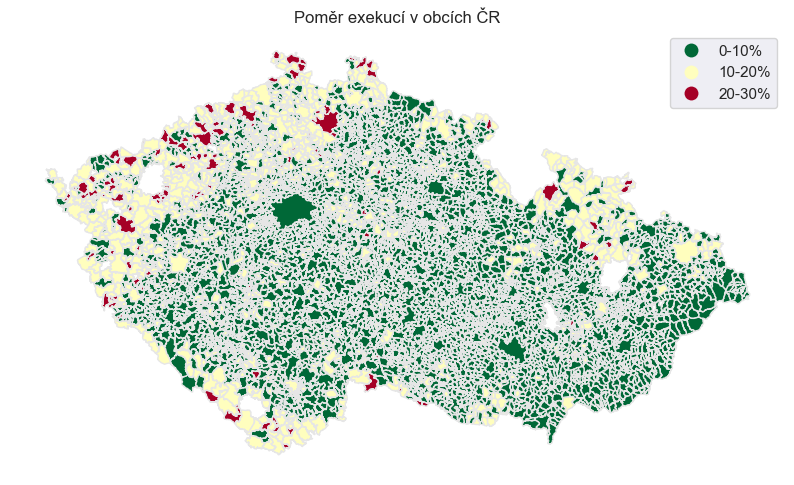

In [24]:
map_df['re_score'] = pd.cut(map_df['re'], bins=[0, 0.1, 0.2, 0.3, 1.0], labels=['0-10%', '10-20%', '20-30%', '+30%'])

fig, ax = plt.subplots(1, figsize=(10,6))
map_df.plot(column='re_score', linewidth=1, ax=ax, edgecolor='0.9', legend = True, cmap='RdYlGn_r')
ax.axis('off')
ax.set_title('Poměr exekucí v obcích ČR')


Text(0.5, 1.0, 'Skóre vzdělanosti v obcích ČR')

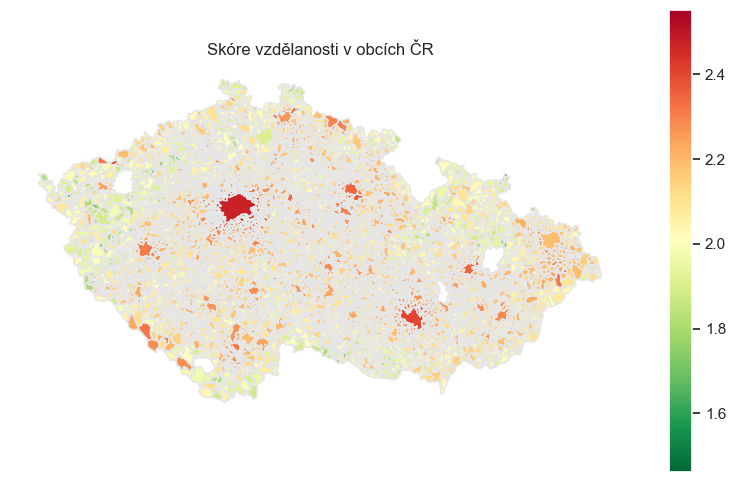

In [6]:
# vzdelani v obcích - choropleth map
# skórizovat vzdelani
#   1: základní vzdělání
#   2: středoškolské vzdělání bez maturity 
#   2.5: středoškolské vzdělání s maturitou
#   2.75: vyšší odborné vzdělání
#   3: vysokoškolské vzdělání

map_df['vzdelanych']=(map_df['Základní vzdělání']+map_df['Středoškolské vzdělání bez maturity']+map_df['Středoškolské vzdělání s maturitou']+map_df['Vysokoškolské vzdělání'])
map_df['vzdelani_score'] =(1*map_df['Základní vzdělání']+2*map_df['Středoškolské vzdělání bez maturity']+2.5*map_df['Středoškolské vzdělání s maturitou']+2.75*map_df['Vyšší odborné vzdělání']+3*map_df['Vysokoškolské vzdělání'])
map_df['vzdelani_score'] = map_df['vzdelani_score'] / map_df['vzdelanych']

fig, ax = plt.subplots(1, figsize=(10,6))
map_df.plot(column='vzdelani_score', linewidth=1, ax=ax, edgecolor='0.9', legend = True, cmap='RdYlGn_r')
ax.axis('off')
ax.set_title('Skóre vzdělanosti v obcích ČR')


Text(0.5, 1.0, 'Vysoškolské vzdělání v obcích ČR')

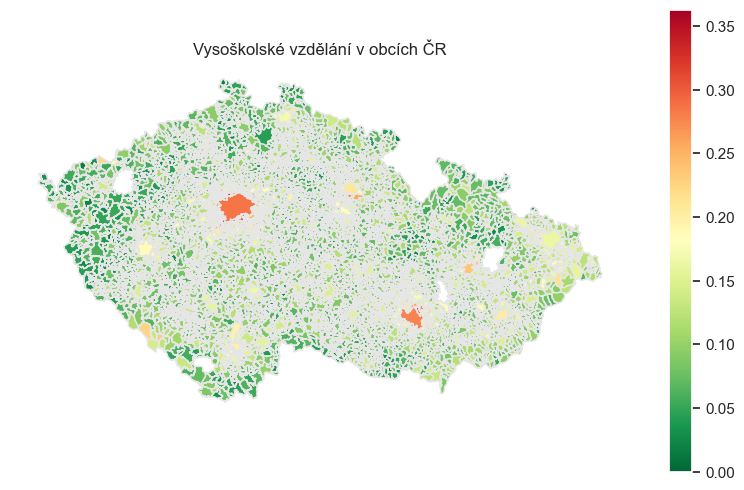

In [9]:
# Vysokoškolské vzdělání

fig, ax = plt.subplots(1, figsize=(10,6))
map_df.plot(column='Vysokoškolské vzdělání', linewidth=1, ax=ax, edgecolor='0.9', legend = True, cmap='RdYlGn_r')
ax.axis('off')
ax.set_title('Vysoškolské vzdělání v obcích ČR')


Text(0.5, 1.0, 'Velikost obce')

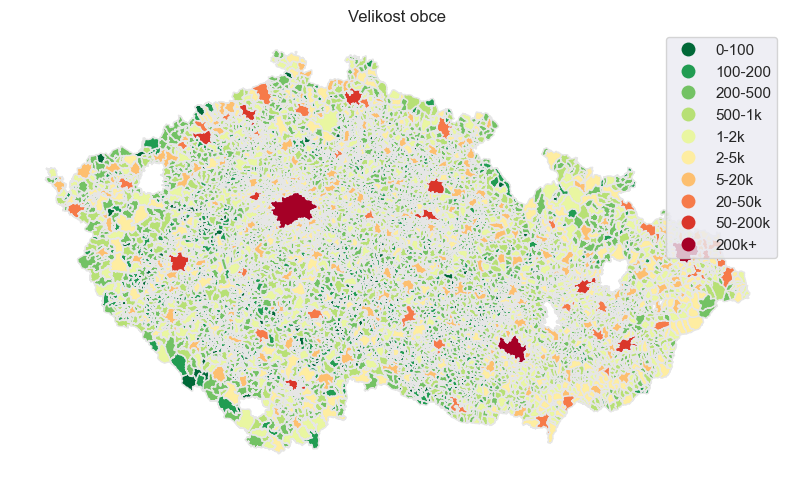

In [7]:
# Velikost obce - choropleth map
# oD.cat (kategorická hodnota velikosti obce)

fig, ax = plt.subplots(1, figsize=(10,6))
map_df.plot(column='oD.cat', linewidth=1, ax=ax, edgecolor='0.9', legend = True, cmap='RdYlGn_r')
ax.axis('off')
ax.set_title('Velikost obce')


Text(0.5, 1.0, 'Počet rozvedených v obci')

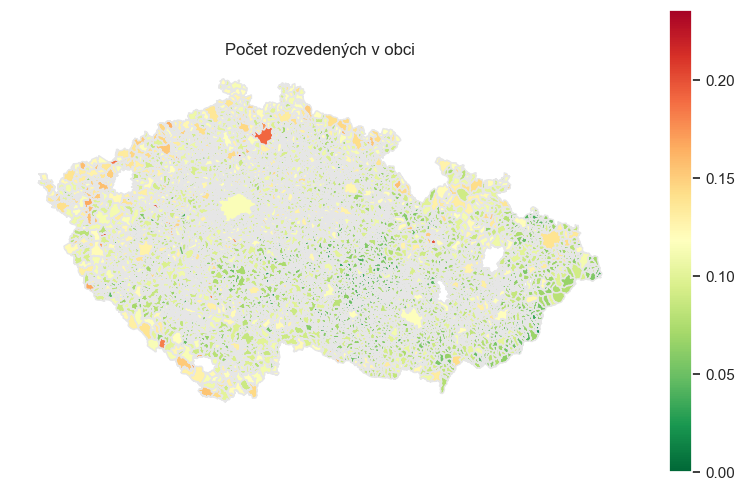

In [8]:
# Rozvedených v obci - choropleth map
# rod_stav_rozv_mean

fig, ax = plt.subplots(1, figsize=(10,6))
map_df.plot(column='rod_stav_rozv_mean', linewidth=1, ax=ax, edgecolor='0.9', legend = True, cmap='RdYlGn_r')
ax.axis('off')
ax.set_title('Počet rozvedených v obci')


Text(0.5, 1.0, 'Potencionální hypoteční závazky na novostavbách')

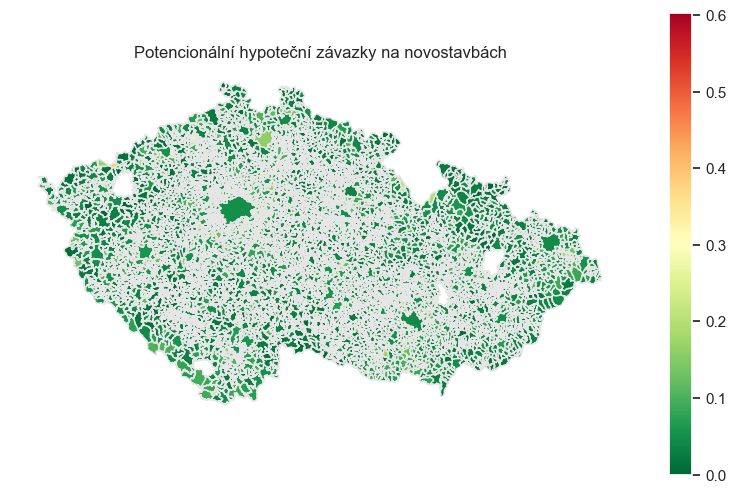

In [10]:
# Novostavby / nové rekonstrukce - choropleth map
# zadlužení na hypotékách

fig, ax = plt.subplots(1, figsize=(10,6))
map_df.plot(column='domy_obd_2016_2021', linewidth=1, ax=ax, edgecolor='0.9', legend = True, cmap='RdYlGn_r')
ax.axis('off')
ax.set_title('Potencionální hypoteční závazky na novostavbách')


Text(0.5, 1.0, 'Poměr bezdětných v obci')

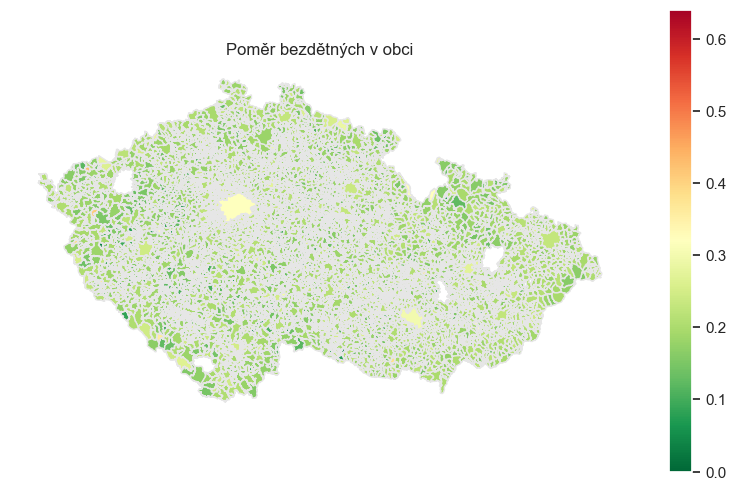

In [15]:
# Bezdětných v obci - choropleth map

fig, ax = plt.subplots(1, figsize=(10,6))
map_df.plot(column='deti_0_2021', linewidth=1, ax=ax, edgecolor='0.9', legend = True, cmap='RdYlGn_r')
ax.axis('off')
ax.set_title('Poměr bezdětných v obci')


# Výsledky